# Database

In this file the dataset is created in which the graph data will be stored. First part is to read the *.dem* files of the matches played on inferno, than convert the datas into ***HeteroData*** structure so that it can be stored in a PyG database.

In [1]:
# Torch
import torch
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.data import Dataset, Data

# Data manipulation
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
from math import floor, ceil
from joblib import dump, load
import os

# Pandas display options
pd.set_option('display.max_columns', 1300)
pd.set_option('display.max_rows', 100)

In [2]:
# Graph related path constants
PATH_GRAPH_NODES_FOLDER = '../../data/inferno_graph/graph_models/manual/'
PATH_GRAPH_NODES = '../../data/inferno_graph/graph_models/manual/nodes_v1_5.csv'
PATH_GRAPH_EDGES = '../../data/inferno_graph/graph_models/manual/edges_v1_5.csv'

# Demo related path constants
PATH_PARSED_DEMOS_2023 = '../../data/demo-parsed/2023'
PATH_PARSED_DEMOS_2022 = '../../data/demo-parsed/2022'

# Player stats related path constants
PATH_PLAYER_STATS = '../../data/player-stats/scraped-in-2024/2022/norm_imputed_player_stats_2022_utf.csv'

# Model related path constants
PATH_MODEL_FOLDER = '../../model/'

In [3]:
class InfernoDataset(Dataset):
    def __init__(self, data_list):
        super(InfernoDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [ ]:
# Operations:
#
# infdataset = InfernoDataset([data])
# torch.save(infdataset, './data/_/test_dataset.pt')
# dataset = torch.load('./data/_/test_dataset.pt')
# loader = DataLoader(infdataset, batch_size=1, shuffle=True)

----
## 1. Step

In this part, general functions are written in order to begin the workflow:
  - Declare file paths
  - Collect inferno matches

Collecting the list of the inferno matches.

In [3]:
def get_inferno_matches(folder_path):
    matches = []
    for filename in os.listdir(folder_path + '/frames/'):
        if 'inferno' in filename:
            matches.append(filename)
    return matches

----
## 2. Step
The workflow of converting one match's data into an overall dataframe in which one row describes 1 snapshot of a game. This result overall dataset will be then used to create the graphs in the next steps. Workflow:

  - Get the necessary dataframes: *playerFrames*, *kills*, *rounds*, *bombEvents*, *damages*
  - Calculate in-match features: *kills*, *opening kills*, *HS kills*, *deaths*, *damages*, etc.
  - Get the dummie columns for the *activeWeapon* of players
  - Create a player object for easier player handle
  - Calculate nearest node to player and store it as a feature
  - Add box-score data (HLTV stats) to the players
  - Create the game snapshot (tabular graph) dataset
  - Add bomb related informations to the game snapshot dataset


Reading *playerFrame*, *kills* and *rounds* dataframes.

In [4]:
def get_needed_dataframes(folder_path, filename):
    playerFrames = pd.read_csv(folder_path + '/playerFrames/' + filename)
    kills = pd.read_csv(folder_path +'/kills/' + filename)
    rounds = pd.read_csv(folder_path +'/rounds/' + filename)
    bombEvents = pd.read_csv(folder_path + '/bombEvents/' + filename)
    damages = pd.read_csv(folder_path + '/damages/' + filename)


    rounds = rounds[['roundNum', 'tScore', "ctScore" ,'endTScore', 'endCTScore']]
    pf = playerFrames[['tick', 'roundNum', 'seconds', 'side', 'name', 'x', 'y', 'z','eyeX', 'eyeY', 'eyeZ', 'velocityX', 'velocityY', 'velocityZ',
        'hp', 'armor', 'activeWeapon','flashGrenades', 'smokeGrenades', 'heGrenades', 'totalUtility', 'isAlive', 'isReloading', 'isBlinded', 'isDucking',
        'isDefusing', 'isPlanting', 'isUnknown', 'isScoped', 'equipmentValue', 'equipmentValueRoundStart', 'hasHelmet','hasDefuse', 'hasBomb']]
    
    return pf, kills, rounds, bombEvents, damages

Formatting the dataframes: Calculate features, in-game live stats, etc.

In [5]:
def calculate_ingame_features_from_needed_dataframes(pf, kills, rounds, damages):
    
    # Merge playerFrames with rounds
    pf = pf.merge(rounds, on='roundNum')

    # Kill stats
    pf['stat_kills'] = 0
    pf['stat_HSK'] = 0
    pf['stat_openKills'] = 0
    pf['stat_tradeKills'] = 0

    # Death stats
    pf['stat_deaths'] = 0
    pf['stat_openDeaths'] = 0

    # Assist stats
    pf['stat_assists'] = 0
    pf['stat_flashAssists'] = 0

    # Damage stats
    pf['stat_damage'] = 0
    pf['stat_weaponDamage'] = 0
    pf['stat_nadeDamage'] = 0
    
    # Setting kill-stats
    for index, row in kills.iterrows():

        # Kills
        pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_kills'] += 1

        # HS-kills
        if row['isHeadshot']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_HSK'] += 1

        # Opening-kills
        if row['isFirstKill']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_openKills'] += 1

        # Trading-kills
        if row['isTrade']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_tradeKills'] += 1

        # Deaths
        pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['victimName']), 'stat_deaths'] += 1

        # Opening deaths
        if row['isFirstKill']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['victimName']), 'stat_openDeaths'] += 1
            
        # Assists
        if pd.notna(row['assisterName']):
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['assisterName']), 'stat_assists'] += 1

        # Flash assists
        if row['victimBlinded'] and row['flashThrowerTeam'] != row['victimTeam']:
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['flashThrowerTeam']), 'stat_flashAssists'] += 1

    # Setting damage-stats
    for index, row in damages.iterrows():

        # All Damage
        if (row['isFriendlyFire'] == False):
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_damage'] += row['hpDamageTaken']

        # Weapon Damage
        if (row['isFriendlyFire'] == False) and (row['weaponClass'] != "Grenade" and row['weaponClass'] != "Equipment"):
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_weaponDamage'] += row['hpDamageTaken']
        
        # Nade Damage
        if (row['isFriendlyFire'] == False) and (row['weaponClass'] == "Grenade"):
            pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'stat_nadeDamage'] += row['hpDamageTaken']
        
    return pf, kills, rounds

Get the dummie columns for active weapons.

In [6]:
def get_activeWeapon_dummies(pf):
    
    # Active weapons
    active_weapons = [
        # Other
        'activeWeapon_C4', 'activeWeapon_Knife', 'activeWeapon_Taser',
        # Pistols
        'activeWeapon_USP-S', 'activeWeapon_P2000', 'activeWeapon_Glock-18', 'activeWeapon_Dual Berettas', 'activeWeapon_P250', 'activeWeapon_Tec-9', 'activeWeapon_CZ75 Auto', 'activeWeapon_Five-SeveN', 'activeWeapon_Desert Eagle',
        # SMGs
        'activeWeapon_MAC-10', 'activeWeapon_MP9', 'activeWeapon_MP7', 'activeWeapon_MP5-SD', 'activeWeapon_UMP-45', 'activeWeapon_PP-Bizon', 'activeWeapon_P90',
        # Heavy
        'activeWeapon_Nova', 'activeWeapon_XM1014', 'activeWeapon_Sawed-Off', 'activeWeapon_MAG-7', 'activeWeapon_M249', 'activeWeapon_Negev',
        # Rifles
        'activeWeapon_FAMAS', 'activeWeapon_Galil AR', 'activeWeapon_AK-47', 'activeWeapon_M4A4', 'activeWeapon_M4A1', 'activeWeapon_SG 553', 'activeWeapon_AUG', 'activeWeapon_SSG 08', 'activeWeapon_AWP', 'activeWeapon_G3SG1', 'activeWeapon_SCAR-20',
        # Grenades
        'activeWeapon_HE Grenade', 'activeWeapon_Flashbang', 'activeWeapon_Smoke Grenade', 'activeWeapon_Incendiary Grenade', 'activeWeapon_Molotov', 'activeWeapon_Decoy Grenade'
    ]

    # Create dummie cols
    df_dummies = pd.get_dummies(pf['activeWeapon'], prefix="activeWeapon",drop_first=False)
    dummies = pd.DataFrame()
    for col in active_weapons:
        if col not in df_dummies.columns:
            dummies[col] = np.zeros(len(df_dummies))
        else:
            dummies[col] = df_dummies[col]
    
    dummies = dummies*1
    pf = pf.merge(dummies, left_index = True, right_index = True, how = 'left')
    
    return pf

Create a player object to store player related data.

Important setting in the flow: how many snapshots per second.

In [7]:
def player_object_create(pf):
    
    startAsCTPlayerNames = pf[(pf['side'] == 'CT') & (pf['roundNum'] == 1)]['name'].unique()
    startAsTPlayerNames = pf[(pf['side'] == 'T') & (pf['roundNum'] == 1)]['name'].unique()
    players = {}

    # Team 1: start on CT side
    players[0] = pf[pf['name'] == startAsCTPlayerNames[0]].iloc[::4].copy()   # .drop_duplicates(subset=['sec','roundNum'])
    players[1] = pf[pf['name'] == startAsCTPlayerNames[1]].iloc[::4].copy()   # .drop_duplicates(subset=['sec','roundNum'])
    players[2] = pf[pf['name'] == startAsCTPlayerNames[2]].iloc[::4].copy()   # .drop_duplicates(subset=['sec','roundNum'])
    players[3] = pf[pf['name'] == startAsCTPlayerNames[3]].iloc[::4].copy()   # .drop_duplicates(subset=['sec','roundNum'])
    players[4] = pf[pf['name'] == startAsCTPlayerNames[4]].iloc[::4].copy()   # .drop_duplicates(subset=['sec','roundNum'])

    # Team 2: start on T side
    players[5] = pf[pf['name'] == startAsTPlayerNames[0]].iloc[::4].copy()   # drop_duplicates(subset=['sec','roundNum']).
    players[6] = pf[pf['name'] == startAsTPlayerNames[1]].iloc[::4].copy()   # drop_duplicates(subset=['sec','roundNum']).
    players[7] = pf[pf['name'] == startAsTPlayerNames[2]].iloc[::4].copy()   # drop_duplicates(subset=['sec','roundNum']).
    players[8] = pf[pf['name'] == startAsTPlayerNames[3]].iloc[::4].copy()   # drop_duplicates(subset=['sec','roundNum']).
    players[9] = pf[pf['name'] == startAsTPlayerNames[4]].iloc[::4].copy()   # drop_duplicates(subset=['sec','roundNum']).
    
    return players


Find closest and n-closest map node neighbors of a player node. 

In [8]:
# Calculate closest map-graph node
def find_closest(row):
    nodes = pd.read_csv(PATH_GRAPH_NODES)
    distances = np.sqrt((nodes['x'] - row['x'])**2 + (nodes['y'] - row['y'])**2)
    return nodes.loc[distances.idxmin(), 'nodeId']

def find_n_closest(row, n=3):
    nodes = pd.read_csv(PATH_GRAPH_NODES)
    distances = np.sqrt((nodes['x'] - row['x'])**2 + (nodes['y'] - row['y'])**2)
    closest_indices = distances.argsort()[:n]
    return nodes.loc[closest_indices, 'nodeId'].tolist()

def player_object_calculate_closest_mapnode_feature(players):

    for idx, player in enumerate(players):
        
        players[idx] = players[idx].replace(True, 1)
        players[idx] = players[idx].replace(False, 0)
        players[idx]['isCT'] = players[idx]['side'].apply(lambda x: 1 if x == 'CT' else 0)
        players[idx]['closestId'] = players[idx].apply(find_closest, axis=1)

        del players[idx]['side']            # Deleted because isCT flag holds the info
        del players[idx]['activeWeapon']    # Deleted because of the activeWeapon_*weapon* dummie columns
    
    return players

Get box-score data for players (HLTV scraped dataset)

In [9]:
def insert_columns_into_player_dataframes(stat_df, players_df):
    for col in stat_df.columns:
        if col != 'player_name':
            players_df[col] = stat_df.loc[stat_df['player_name'] == players_df['name'].iloc[0]][col].iloc[0]
    return players_df



def get_player_overall_statistics_without_inferno(players):
    # Needed columns
    needed_stats = ['player_name', 'rating_2.0', 'DPR', 'KAST', 'Impact', 'ADR', 'KPR','total_kills', 'HS%', 'total_deaths', 'KD_ratio', 'dmgPR',
       'grenade_dmgPR', 'maps_played', 'saved_by_teammatePR', 'saved_teammatesPR','opening_kill_rating', 'team_W%_after_opening',
       'opening_kill_in_W_rounds', 'rating_1.0_all_Career', 'clutches_1on1_ratio', 'clutches_won_1on1', 'clutches_won_1on2', 'clutches_won_1on3', 'clutches_won_1on4', 'clutches_won_1on5']
    
    stats = pd.read_csv(PATH_PLAYER_STATS).drop_duplicates()
    stats = stats[needed_stats]

    # Stats dataframe basic formatting
    for col in stats.columns:
        if col != 'player_name':
            stats[col] = stats[col].astype('float32')
            stats.rename(columns={col: "overall_" + col}, inplace=True)
    
    # Merge stats with players
    for idx in range(0,len(players)):
        # If the stats dataframe contains the player related informations, do the merge
        if len(stats.loc[stats['player_name'] == players[idx]['name'].iloc[0]]) == 1:
            players[idx] = insert_columns_into_player_dataframes(stats, players[idx])

        # If the stats dataframe does not contain the player related informations, check if the missing_players_df contains the player
        else:
            mpdf = pd.read_csv('../../data/player-stats/missing_players_df.csv')
            mpdf = mpdf[needed_stats]
            for col in mpdf.columns:
                if col != 'player_name':
                    mpdf[col] = mpdf[col].astype('float32')
                    mpdf.rename(columns={col: "overall_" + col}, inplace=True)
                    
            # If the missing_players_df contains the player related informations, do the merge
            if len(mpdf.loc[mpdf['player_name'] == players[idx]['name'].iloc[0]]) == 1:
                players[idx] = insert_columns_into_player_dataframes(mpdf, players[idx])

            # Else get imputed values for the player from missing_players_df and do the merge
            else:
                first_anonim_pro_index = mpdf.index[mpdf['player_name'] == 'anonim_pro'].min()
                mpdf.at[first_anonim_pro_index, 'player_name'] = players[idx]['name'].iloc[0]
                mpdf.to_csv('../../data/player-stats/missing_players_df.csv', index=False)
                players[idx] = insert_columns_into_player_dataframes(mpdf, players[idx])
        
    return players

Create the game snapshot (graph) dataset in tabular format 

In [10]:
def calculate_ct_equipment_value(row):
    if row['player0_isCT']:
        return row[['player0_equi_val_alive', 'player1_equi_val_alive', 'player2_equi_val_alive', 'player3_equi_val_alive', 'player4_equi_val_alive']].sum()
    else:
        return row[['player5_equi_val_alive', 'player6_equi_val_alive', 'player7_equi_val_alive', 'player8_equi_val_alive', 'player9_equi_val_alive']].sum()

def calculate_t_equipment_value(row):
    if row['player0_isCT'] == False:
        return row[['player0_equi_val_alive', 'player1_equi_val_alive', 'player2_equi_val_alive', 'player3_equi_val_alive', 'player4_equi_val_alive']].sum()
    else:
        return row[['player5_equi_val_alive', 'player6_equi_val_alive', 'player7_equi_val_alive', 'player8_equi_val_alive', 'player9_equi_val_alive']].sum()



def create_game_snapshot_dataset(players, rounds, match_id):
    # Copy players object
    graph_players = {}
    for idx in range(0,len(players)):
        graph_players[idx] = players[idx].copy()

    colsNotToRename = ['tick', 'roundNum', 'seconds']

    # Rename columns except for tick, roundNum, seconds, floorSec
    for idx in range(0,len(graph_players)):
        
        for col in graph_players[idx].columns:
            if col not in colsNotToRename:
                graph_players[idx].rename(columns={col: "player" + str(idx) + "_" + col}, inplace=True)

    # Create a graph dataframe to store all players in 1 row per second
    graph_data = graph_players[0].copy()

    # Merge dataframes
    for i in range(1, len(graph_players)):
        graph_data = graph_data.merge(graph_players[i], on=colsNotToRename)
        
    graph_data = graph_data.merge(rounds, on=['roundNum'])
    graph_data['CT_winsRound'] = graph_data.apply(lambda x: 1 if (x['endCTScore'] > x['ctScore']) else 0, axis=1)
    graph_data['CT_aliveNum'] = graph_data[['player0_isAlive','player1_isAlive','player2_isAlive','player3_isAlive','player4_isAlive']].sum(axis=1)
    graph_data['T_aliveNum'] = graph_data[['player5_isAlive','player6_isAlive','player7_isAlive','player8_isAlive','player9_isAlive']].sum(axis=1)
    graph_data['player0_equi_val_alive'] = graph_data['player0_equipmentValue'] * graph_data['player0_isAlive']
    graph_data['player1_equi_val_alive'] = graph_data['player1_equipmentValue'] * graph_data['player1_isAlive']
    graph_data['player2_equi_val_alive'] = graph_data['player2_equipmentValue'] * graph_data['player2_isAlive']
    graph_data['player3_equi_val_alive'] = graph_data['player3_equipmentValue'] * graph_data['player3_isAlive']
    graph_data['player4_equi_val_alive'] = graph_data['player4_equipmentValue'] * graph_data['player4_isAlive']
    graph_data['player5_equi_val_alive'] = graph_data['player5_equipmentValue'] * graph_data['player5_isAlive']
    graph_data['player6_equi_val_alive'] = graph_data['player6_equipmentValue'] * graph_data['player6_isAlive']
    graph_data['player7_equi_val_alive'] = graph_data['player7_equipmentValue'] * graph_data['player7_isAlive']
    graph_data['player8_equi_val_alive'] = graph_data['player8_equipmentValue'] * graph_data['player8_isAlive']
    graph_data['player9_equi_val_alive'] = graph_data['player9_equipmentValue'] * graph_data['player9_isAlive']
    graph_data['CT_equipmentValue'] = graph_data.apply(calculate_ct_equipment_value, axis=1)
    graph_data['T_equipmentValue'] = graph_data.apply(calculate_t_equipment_value, axis=1)
    del graph_data['player0_equi_val_alive']
    del graph_data['player1_equi_val_alive']
    del graph_data['player2_equi_val_alive']
    del graph_data['player3_equi_val_alive']
    del graph_data['player4_equi_val_alive']
    del graph_data['player5_equi_val_alive']
    del graph_data['player6_equi_val_alive']
    del graph_data['player7_equi_val_alive']
    del graph_data['player8_equi_val_alive']
    del graph_data['player9_equi_val_alive']


    # Create a DataFrame with a single column for match_id
    match_id_df = pd.DataFrame({'match_id': str(match_id)}, index=graph_data.index)
    graph_data_concatenated = pd.concat([graph_data, match_id_df], axis=1)
    
    return graph_data_concatenated

Add Bomb related information to graph level data

In [11]:
def add_bomb_related_information_to_game_snapshot_dataset(gsndf, bombdf):
    gsndf['is_bomb_being_planted'] = 0
    gsndf['is_bomb_planted'] = 0
    gsndf['is_bomb_being_defused'] = 0
    gsndf['is_bomb_defused'] = 0
    gsndf['is_bomb_planted_at_A_site'] = 0
    gsndf['bomb_X'] = 0.0
    gsndf['bomb_Y'] = 0.0
    gsndf['bomb_Z'] = 0.0

    for index, row in bombdf.iterrows():
        if (row['bombAction'] == 'plant_begin'):
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_being_planted'] = 1

        if (row['bombAction'] == 'plant_abort'):
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_being_planted'] = 0

        if (row['bombAction'] == 'plant'):
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_being_planted'] = 0
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_planted'] = 1
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_planted_at_A_site'] = 1 if row['bombSite'] == 'A' else 0
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'bomb_X'] = row['playerX']
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'bomb_Y'] = row['playerY']
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'bomb_Z'] = row['playerZ']

        if (row['bombAction'] == 'defuse_start'):
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_being_defused'] = 1

        if (row['bombAction'] == 'defuse_aborted'):
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_being_defused'] = 0

        if (row['bombAction'] == 'defuse'):
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_being_defused'] = 0
            gsndf.loc[(gsndf['roundNum'] == row['roundNum']) & (gsndf['tick'] >= row['tick']), 'is_bomb_defused'] = 1

    return gsndf

----
## 3. Step

Create graph dataset

Read inferno graph model.

In [82]:
def get_inferno_graph_nodes_and_edges():
    nodes = pd.read_csv(PATH_GRAPH_NODES)
    edges = pd.read_csv(PATH_GRAPH_EDGES)
    
    nodes['x'] = nodes['x'].astype('float32')
    nodes['y'] = nodes['y'].astype('float32')
    nodes['isPath'] = nodes['type'].apply(lambda x: 1 if x == 'path' else 0)
    
    return nodes, edges

Get player edges dataset

In [ ]:
def create_playerEdges_dataframe(players):
    
    playerEdges = None

    for idx in range(0,len(players)):
        temp = players[idx][['roundNum','sec','closestId']].copy()
        temp['playerId'] = idx
        if playerEdges is None:
            playerEdges = temp
        else:
            playerEdges = pd.concat([playerEdges, temp])
    
    return playerEdges

Format player data for HeteroData object creation.

In [84]:
def create_playerFrameData_for_graph(players, roundNum, sec):
    playerFrameData = pd.DataFrame(columns=players[0].columns)
    for idx in range(0,len(players)):
        playerFrameData.loc[idx] = players[idx].loc[(players[idx]['roundNum'] == roundNum) & (players[idx]['sec'] == sec)].iloc[0]
        
    playerFrameData.drop(columns=['tick', 'roundNum', 'seconds', 'name', 'closestId'], inplace=True)
    playerFrameData = playerFrameData.astype('float32')
    
    return playerFrameData

Create the HeteroData object.

In [85]:
def create_HeteroData(playerFrameData, playerEdges, graph_data, nodes, edges, roundNum, sec):
    data = HeteroData()

    # Create a sample heterogeneous graph with node, edge, and multiple graph-level features
    data['player'].x = torch.tensor(playerFrameData.astype('float32').values)
    data['map'].x = torch.tensor(nodes[['x','y','isPath']].astype('float32').values)

    data['map', 'connected_to', 'map'].edge_index = torch.tensor(edges.T.values)
    data['player', 'closest_to', 'map'].edge_index = torch.tensor(playerEdges.loc[ (playerEdges['roundNum'] == roundNum) & (playerEdges['sec'] == sec)][['playerId','closestId']].T.values)


    # Define multiple graph-level features
    data.y = {
        'roundNum': roundNum.astype('float32'),
        'sec': sec.astype('float32'),
        'team1AliveNum': torch.tensor(graph_data.loc[ (graph_data['roundNum'] == roundNum) & (graph_data['sec'] == sec)]['team1AliveNum'].iloc[0].astype('float32')),
        'team2AliveNum': torch.tensor(graph_data.loc[ (graph_data['roundNum'] == roundNum) & (graph_data['sec'] == sec)]['team2AliveNum'].iloc[0].astype('float32')),
        'CTwinsRound': torch.tensor(graph_data.loc[ (graph_data['roundNum'] == roundNum) & (graph_data['sec'] == sec)]['CTwinsRound'].iloc[0])
    }
    
    return data

---------
## Creating the tabular dataset

In [12]:
# Consts
FOLDER_READ_PATH = '../../data/demo-parsed/2023'
FOLDER_SAVE_PATH = '../../data/graph-dataset/semester-2/tabular'
STORE_LAST_SAVED_MATCH_TXT_PATH = '../../data/graph-dataset/semester-2/tabular/last-saved-match.txt'

# Params for workflow
save_df = pd.DataFrame()
reached_last_save = False
last_saved = ''

# Get matches
matches = get_inferno_matches(FOLDER_READ_PATH)

# Get last saved demo
try:
    with open(STORE_LAST_SAVED_MATCH_TXT_PATH, 'r') as file:
        last_saved = file.read()
except:
    last_saved = ''

# Start the creation of graphs
for idx, match in enumerate(matches):

    # Skip the matches with damaged data structure
    if match == 'blast-premier-spring-final-2023-g2-vs-cloud9-bo3-l6_WROLL2MODdQ0NexGWUJg2-vs-cloud9-m2-inferno.dem.csv'  or \
       match == 'iem-cologne-2023-g2-vs-faze-bo3-2rs0vwSX-MC7GnSL4ITW06g2-vs-faze-m1-inferno.dem.csv' or \
       match == 'iem-cologne-2023-g2-vs-astralis-bo3-_w4eg3Jhwy1dhctFRgGSl7g2-vs-astralis-m2-inferno.dem.csv' or \
       match == 'iem-katowice-2023-faze-vs-ihc-bo3-xzdrX8BWDhgJKqFJblorpafaze-vs-ihc-m1-inferno.dem.csv':
        continue
    
    # Skip already processed demos
    if last_saved == '':
        reached_last_save = True
    elif last_saved != match and reached_last_save == False:
        continue
    elif last_saved == match and reached_last_save == False:
        reached_last_save = True
        continue
    
    # Create graph
    pf, kills, rounds, bombEvents, damages = get_needed_dataframes(FOLDER_READ_PATH, match)
    pf, kills, rounds = calculate_ingame_features_from_needed_dataframes(pf, kills, rounds, damages)
    pf = get_activeWeapon_dummies(pf)
    players = player_object_create(pf)
    players = player_object_calculate_closest_mapnode_feature(players)
    players = get_player_overall_statistics_without_inferno(players)
    graph_data = create_game_snapshot_dataset(players, rounds, match)
    graph_data = add_bomb_related_information_to_game_snapshot_dataset(graph_data.copy(), bombEvents)

    # Add graph_data to the save_df dataset
    if (len(save_df) == 0):
        save_df = graph_data
    else:
        save_df = pd.concat([save_df, graph_data])

    # After 5 matches, save the dataset
    if idx % 5 == 0:
        save_df.to_csv(FOLDER_SAVE_PATH + '/df_' + str(round(idx/5)) + '.csv', index=False)
        del save_df
        save_df = pd.DataFrame()
        with open(STORE_LAST_SAVED_MATCH_TXT_PATH, 'w') as file:
            file.write(match)
        print(match)
    
    # If the last match is reached, save the dataset
    if idx == len(matches)-1:
        save_df.to_csv(FOLDER_SAVE_PATH + '/df_last.csv', index=False)
        del save_df
        with open(STORE_LAST_SAVED_MATCH_TXT_PATH, 'w') as file:
            file.write(match)
        print(match)
        print('done')

blast-premier-fall-groups-2023-evil-geniuses-vs-g2-bo3-skJ60UDCIzjbZIG70cNfnjevil-geniuses-vs-g2-m1-inferno.dem.csv
blast-premier-fall-groups-2023-heroic-vs-natus-vincere-bo3-aYxoA0Ino9Byq66kU4nUk7heroic-vs-natus-vincere-m2-inferno.dem.csv
blast-premier-fall-groups-2023-og-vs-g2-bo3-CZpHTqhsvNQYrS-XkwQ_Clog-vs-g2-m2-inferno.dem.csv
blast-premier-spring-final-2023-heroic-vs-complexity-bo3-Hna8zpIUa7IFWfaM7WQiwWheroic-vs-complexity-m1-inferno.dem.csv
blast-premier-spring-groups-2023-big-vs-ninjas-in-pyjamas-bo3-AyhscMs-NNQTR5B8iW0IHGbig-vs-ninjas-in-pyjamas-m2-inferno.dem.csv
blast-premier-spring-groups-2023-g2-vs-big-bo3-MksVhtpFuL0wxMkJDDYruvg2-vs-big-m2-inferno.dem.csv
blast-premier-spring-groups-2023-heroic-vs-evil-geniuses-bo3-znpMBVzqH98nzWRa3W-Q7Zheroic-vs-evil-geniuses-m1-inferno.dem.csv
blasttv-paris-major-2023-9ine-vs-faze-bo3-BnPr2sJGP8xGUNbOOXOgEm9ine-vs-faze-m1-inferno.dem.csv
blasttv-paris-major-2023-fnatic-vs-into-the-breach-bo3-n2bK0M-1cLDmn_5Wl2TMRNfnatic-vs-into-the-bre

----
## 4. Step

Tabular dataset small fixes: time, delete useless player feature, add numerical match id, etc.

In [9]:
def format_tabular_dataset(df):
    # Get round start tick and use it to calculate the time remaining in the round
    roundStartTick = df[['match_id', 'roundNum', 'tick']].drop_duplicates(subset=['match_id', 'roundNum']).rename(columns={"tick": "roundStartTick"}).copy()
    df = df.merge(roundStartTick, on=['match_id', 'roundNum'])
    df['sec'] = (df['tick'] - df['roundStartTick']) / 128
    df['time_remaining'] = 115 - df['sec']

    # Get bomb start tick and use it to calculate the time remaining in the round after the bomb is planted
    bombStartDf = df.loc[df['is_bomb_planted'] == 1][['match_id', 'roundNum', 'tick']].drop_duplicates(subset=['match_id', 'roundNum']).rename(columns={"tick": "bombStartTick"}).copy()
    df = df.merge(bombStartDf, on=['match_id', 'roundNum'], how='left')
    df['bombStartTick'].fillna(-1, inplace=True)
    df['bombSec'] = (df['tick'] - df['bombStartTick']) / 128
    df.loc[df['is_bomb_planted'] == 1, 'time_remaining'] = 40 - df['bombSec']

    # Drop unnecessary columns
    del df['roundStartTick']
    del df['bombStartTick']
    del df['bombSec']
    del df['sec']           # Stored in remaining time feature
    del df['seconds']       # Stored in remaining time feature

    for i in range(0,10):
        del df['player{}_tScore'.format(i)]
        del df['player{}_ctScore'.format(i)]
        del df['player{}_endTScore'.format(i)]
        del df['player{}_endCTScore'.format(i)]

    return df

In [13]:
def add_numerical_match_id(df, match_index, match_index_dictionary):
    match_ids = df['match_id'].unique()
    for idx, match_id in enumerate(match_ids):
        df.loc[df['match_id'] == match_id, 'numerical_match_id'] = match_index
        match_index_dictionary.append([match_index + idx, match_id])
        match_index = match_index + 1
    return df, match_index, match_index_dictionary

----
## Format the tabular dataset

In [11]:
TABULAR_DATASET_PATH = '../../data/graph-dataset/semester-2/tabular/'
FORM_TABULAR_DATASET_PATH = '../../data/graph-dataset/semester-2/form-tabular/'

for i in range(0, 28):
    df = pd.read_csv(TABULAR_DATASET_PATH + 'df_' + str(i) + '.csv')
    df = format_tabular_dataset(df)
    df.to_csv(FORM_TABULAR_DATASET_PATH + 'form_df_' + str(i) + '.csv', index=False)
    print('df_' + str(i) + '.csv is formatted.')

df_0.csv is formatted.
df_1.csv is formatted.
df_2.csv is formatted.
df_3.csv is formatted.
df_4.csv is formatted.
df_5.csv is formatted.
df_6.csv is formatted.
df_7.csv is formatted.
df_8.csv is formatted.
df_9.csv is formatted.
df_10.csv is formatted.
df_11.csv is formatted.
df_12.csv is formatted.
df_13.csv is formatted.
df_14.csv is formatted.
df_15.csv is formatted.
df_16.csv is formatted.
df_17.csv is formatted.


C:\Users\szmid\AppData\Local\Temp\ipykernel_22728\3688826970.py:5: DtypeWarning: Columns (3,794) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TABULAR_DATASET_PATH + 'df_' + str(i) + '.csv')


df_18.csv is formatted.
df_19.csv is formatted.
df_20.csv is formatted.
df_21.csv is formatted.
df_22.csv is formatted.
df_23.csv is formatted.
df_24.csv is formatted.
df_25.csv is formatted.
df_26.csv is formatted.
df_27.csv is formatted.


In [14]:
FORM_TABULAR_DATASET_PATH = '../../data/graph-dataset/semester-2/form-tabular/'

match_index = 1000
match_index_dictionary = []

for i in range(0, 28):
    df = pd.read_csv(FORM_TABULAR_DATASET_PATH + 'form_df_' + str(i) + '.csv')
    df, match_index, match_index_dictionary = add_numerical_match_id(df, match_index, match_index_dictionary)
    df.to_csv(FORM_TABULAR_DATASET_PATH + 'form_df_' + str(i) + '.csv', index=False)
    print('form_df_' + str(i) + '.csv is numerically indexed.')

pd.DataFrame(match_index_dictionary, columns=['numerical_match_id', 'match_id']).to_csv(FORM_TABULAR_DATASET_PATH + 'match_index_dictionary.csv', index=False)

form_df_0.csv is numerically indexed.
form_df_1.csv is numerically indexed.
form_df_2.csv is numerically indexed.
form_df_3.csv is numerically indexed.
form_df_4.csv is numerically indexed.
form_df_5.csv is numerically indexed.
form_df_6.csv is numerically indexed.
form_df_7.csv is numerically indexed.
form_df_8.csv is numerically indexed.
form_df_9.csv is numerically indexed.
form_df_10.csv is numerically indexed.
form_df_11.csv is numerically indexed.
form_df_12.csv is numerically indexed.
form_df_13.csv is numerically indexed.
form_df_14.csv is numerically indexed.
form_df_15.csv is numerically indexed.
form_df_16.csv is numerically indexed.
form_df_17.csv is numerically indexed.


C:\Users\szmid\AppData\Local\Temp\ipykernel_22728\658175948.py:7: DtypeWarning: Columns (2,765) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FORM_TABULAR_DATASET_PATH + 'form_df_' + str(i) + '.csv')


form_df_18.csv is numerically indexed.
form_df_19.csv is numerically indexed.
form_df_20.csv is numerically indexed.
form_df_21.csv is numerically indexed.
form_df_22.csv is numerically indexed.
form_df_23.csv is numerically indexed.
form_df_24.csv is numerically indexed.
form_df_25.csv is numerically indexed.
form_df_26.csv is numerically indexed.
form_df_27.csv is numerically indexed.


----
## 5. Step

Normalization of formatted dataset

In [23]:
non_player_columns = [col for col in df.columns if not col.startswith('player')]
player_without_overall_columns = [col for col in df.columns if col.startswith('player') and 
                                  'overall' not in col and 
                                  'closestId' not in col and 
                                  'name' not in col and
                                  'activeWeapon' not in col]
df[player_without_overall_columns]

,player0_x,player0_y,player0_z,player0_eyeX,player0_eyeY,player0_eyeZ,player0_velocityX,player0_velocityY,player0_velocityZ,player0_hp,player0_armor,player0_flashGrenades,player0_smokeGrenades,player0_heGrenades,player0_totalUtility,player0_isAlive,player0_isReloading,player0_isBlinded,player0_isDucking,player0_isDefusing,player0_isPlanting,player0_isUnknown,player0_isScoped,player0_equipmentValue,player0_equipmentValueRoundStart,player0_hasHelmet,player0_hasDefuse,player0_hasBomb,player0_stat_kills,player0_stat_HSK,player0_stat_openKills,player0_stat_tradeKills,player0_stat_deaths,player0_stat_openDeaths,player0_stat_assists,player0_stat_flashAssists,player0_stat_damage,player0_stat_weaponDamage,player0_stat_nadeDamage,player0_isCT,player1_x,player1_y,player1_z,player1_eyeX,player1_eyeY,player1_eyeZ,player1_velocityX,player1_velocityY,player1_velocityZ,player1_hp,player1_armor,player1_flashGrenades,player1_smokeGrenades,player1_heGrenades,player1_totalUtility,player1_isAlive,player1_isReloading,player1_isBlinded,player1_isDucking,player1_isDefusing,player1_isPlanting,player1_isUnknown,player1_isScoped,player1_equipmentValue,player1_equipmentValueRoundStart,player1_hasHelmet,player1_hasDefuse,player1_hasBomb,player1_stat_kills,player1_stat_HSK,player1_stat_openKills,player1_stat_tradeKills,player1_stat_deaths,player1_stat_openDeaths,player1_stat_assists,player1_stat_flashAssists,player1_stat_damage,player1_stat_weaponDamage,player1_stat_nadeDamage,player1_isCT,player2_x,player2_y,player2_z,player2_eyeX,player2_eyeY,player2_eyeZ,player2_velocityX,player2_velocityY,player2_velocityZ,player2_hp,player2_armor,player2_flashGrenades,player2_smokeGrenades,player2_heGrenades,player2_totalUtility,player2_isAlive,player2_isReloading,player2_isBlinded,player2_isDucking,player2_isDefusing,player2_isPlanting,player2_isUnknown,player2_isScoped,player2_equipmentValue,player2_equipmentValueRoundStart,player2_hasHelmet,player2_hasDefuse,player2_hasBomb,player2_stat_kills,player2_stat_HSK,player2_stat_openKills,player2_stat_tradeKills,player2_stat_deaths,player2_stat_openDeaths,player2_stat_assists,player2_stat_flashAssists,player2_stat_damage,player2_stat_weaponDamage,player2_stat_nadeDamage,player2_isCT,player3_x,player3_y,player3_z,player3_eyeX,player3_eyeY,player3_eyeZ,player3_velocityX,player3_velocityY,player3_velocityZ,player3_hp,player3_armor,player3_flashGrenades,player3_smokeGrenades,player3_heGrenades,player3_totalUtility,player3_isAlive,player3_isReloading,player3_isBlinded,player3_isDucking,player3_isDefusing,player3_isPlanting,player3_isUnknown,player3_isScoped,player3_equipmentValue,player3_equipmentValueRoundStart,player3_hasHelmet,player3_hasDefuse,player3_hasBomb,player3_stat_kills,player3_stat_HSK,player3_stat_openKills,player3_stat_tradeKills,player3_stat_deaths,player3_stat_openDeaths,player3_stat_assists,player3_stat_flashAssists,player3_stat_damage,player3_stat_weaponDamage,player3_stat_nadeDamage,player3_isCT,player4_x,player4_y,player4_z,player4_eyeX,player4_eyeY,player4_eyeZ,player4_velocityX,player4_velocityY,player4_velocityZ,player4_hp,player4_armor,player4_flashGrenades,player4_smokeGrenades,player4_heGrenades,player4_totalUtility,player4_isAlive,player4_isReloading,player4_isBlinded,player4_isDucking,player4_isDefusing,player4_isPlanting,player4_isUnknown,player4_isScoped,player4_equipmentValue,player4_equipmentValueRoundStart,player4_hasHelmet,player4_hasDefuse,player4_hasBomb,player4_stat_kills,player4_stat_HSK,player4_stat_openKills,player4_stat_tradeKills,player4_stat_deaths,player4_stat_openDeaths,player4_stat_assists,player4_stat_flashAssists,player4_stat_damage,player4_stat_weaponDamage,player4_stat_nadeDamage,player4_isCT,player5_x,player5_y,player5_z,player5_eyeX,player5_eyeY,player5_eyeZ,player5_velocityX,player5_velocityY,player5_velocityZ,player5_hp,player5_armor,player5_flashGrenades,player5_smokeGrenades,player5_heGrenades,player5_totalUtility,player5_isAlive,player5_isReloading,player5_isBlinded,pla

In [4]:
def normalize_inferno_graph_node_dataset():
    nodes = pd.read_csv(PATH_GRAPH_NODES)
    scaler = MinMaxScaler()
    scaler.fit(nodes[['x', 'y']])
    nodes[['x', 'y']] = scaler.transform(nodes[['x', 'y']])
    nodes.to_csv(PATH_GRAPH_NODES_FOLDER + 'nodes_normalized.csv', index=False)
    dump(scaler, PATH_MODEL_FOLDER + 'inferno_graph_scaler.pkl')
    

In [5]:
normalize_inferno_graph_node_dataset()

In [ ]:
FORM_TABULAR_DATASET_PATH = '../../data/graph-dataset/semester-2/form-tabular/'

def create_normalized_dataset():

    # Get overall dataframe
    for i in range(0, 28):
        temp = pd.read_csv(FORM_TABULAR_DATASET_PATH + 'form_df_' + str(i) + '.csv')
        if i == 0:
            df = temp
        else:
            df = pd.concat([df, temp])

    non_player_columns = [col for col in df.columns if not col.startswith('player')]

----
## Create Heterogeneous graph dataset

In [ ]:
# Consts
FOLDER_READ_PATH = '../../data/demo-parsed/2023'
FOLDER_SAVE_PATH = './graph-dataset/semester-2/tabular'
LAST_SAVED_TXT_PATH = './graph-dataset/last-saved.txt'

# Params for workflow
hetero_data_list = []
reached_last_save = False
last_saved = ''

# Get matches
matches = get_inferno_matches(FOLDER_READ_PATH)

# Get last saved demo
try:
    with open(LAST_SAVED_TXT_PATH, 'r') as file:
        last_saved = file.read()
except:
    last_saved = ''

# Start the creation of graphs
for idx, match in enumerate(matches):

    # Skip the matches with damaged data structure
    if match == 'blast-premier-spring-final-2023-g2-vs-cloud9-bo3-l6_WROLL2MODdQ0NexGWUJg2-vs-cloud9-m2-inferno.dem.csv'  or \
       match == 'iem-cologne-2023-g2-vs-faze-bo3-2rs0vwSX-MC7GnSL4ITW06g2-vs-faze-m1-inferno.dem.csv' or \
       match == 'iem-cologne-2023-g2-vs-astralis-bo3-_w4eg3Jhwy1dhctFRgGSl7g2-vs-astralis-m2-inferno.dem.csv' or \
       match == 'iem-katowice-2023-faze-vs-ihc-bo3-xzdrX8BWDhgJKqFJblorpafaze-vs-ihc-m1-inferno.dem.csv':
        continue
    
    # Skip already processed demos
    if last_saved == '':
        reached_last_save = True
    elif last_saved != match and reached_last_save == False:
        continue
    elif last_saved == match and reached_last_save == False:
        reached_last_save = True
        continue
    
    # Create graph
    pf, kills, rounds, bombEvents, damages = get_needed_dataframes(FOLDER_READ_PATH, match)
    pf, kills, rounds = calculate_ingame_features_from_needed_dataframes(pf, kills, rounds, damages)
    pf = get_activeWeapon_dummies(pf)
    players = player_object_create(pf)
    players = player_object_calculate_closest_mapnode_feature(players)
    players = get_player_overall_statistics_without_inferno(players)
    player_edges = create_playerEdges_dataframe(players)
    graph_data = create_game_snapshot_dataset(players, rounds)
    nodes, edges = get_inferno_graph_nodes_and_edges()

    rounds_list = pf['roundNum'].unique()
    for roundNum in rounds_list:
        sec_list = pf[pf['roundNum'] == roundNum]['sec'].unique()
        for sec in sec_list:
            playerFrameData = create_playerFrameData_for_graph(players, roundNum, sec)
            data = create_HeteroData(playerFrameData, player_edges, graph_data, nodes, edges, roundNum, sec)
            hetero_data_list.append(data)
        print(match,roundNum)
    
    if idx % 5 == 0:
        if os.path.exists('./data/inferno_graph_dataset_3.pt') == False:
            infdataset = InfernoDataset(hetero_data_list)
            torch.save(infdataset, './data/inferno_graph_dataset_3.pt')
            hetero_data_list = []
        elif os.path.exists('./data/inferno_graph_dataset_3.pt') == True:
            infdataset = torch.load('./data/inferno_graph_dataset_3.pt')
            infdataset.data_list = infdataset.data_list + hetero_data_list
            torch.save(infdataset, './data/inferno_graph_dataset_3.pt')
            hetero_data_list = []
        
        with open('last-saved.txt', 'w') as file:
            file.write(match)

----------
# Playground

### 1. Workflow test

In [12]:
FOLDER_PATH = '../../data/demo-parsed/2023'
MATCH_ID = 'blast-premier-fall-groups-2023-evil-geniuses-vs-ninjas-in-pyjamas-bo3-CPA1fpqPPmokg1JWadIIYrevil-geniuses-vs-ninjas-in-pyjamas-m1-inferno.dem.csv'
MATCH_ID_2 = 'blast-premier-fall-groups-2023-faze-vs-liquid-bo3-baXpV-xGqlE-U81KeodtL2faze-vs-liquid-m1-inferno.dem.csv'


pf, kills, rounds, bombEvents, damages = get_needed_dataframes(FOLDER_PATH, MATCH_ID)
pf, kills, rounds = calculate_ingame_features_from_needed_dataframes(pf, kills, rounds, damages)
pf = get_activeWeapon_dummies(pf)
players = player_object_create(pf)
players = player_object_calculate_closest_mapnode_feature(players)
players = get_player_overall_statistics_without_inferno(players)
graph_data = create_game_snapshot_dataset(players, rounds, MATCH_ID)
graph_data = add_bomb_related_information_to_game_snapshot_dataset(graph_data.copy(), bombEvents)

graph_data

In [26]:
graph_data.loc[graph_data['roundNum'] == 13].tail(1)

,tick,roundNum,seconds,player0_name,player0_x,player0_y,player0_z,player0_eyeX,player0_eyeY,player0_eyeZ,player0_velocityX,player0_velocityY,player0_velocityZ,player0_hp,player0_armor,player0_flashGrenades,player0_smokeGrenades,player0_heGrenades,player0_totalUtility,player0_isAlive,player0_isReloading,player0_isBlinded,player0_isDucking,player0_isDefusing,player0_isPlanting,player0_isUnknown,player0_isScoped,player0_equipmentValue,player0_equipmentValueRoundStart,player0_hasHelmet,player0_hasDefuse,player0_hasBomb,player0_tScore,player0_ctScore,player0_endTScore,player0_endCTScore,player0_stat_kills,player0_stat_HSK,player0_stat_openKills,player0_stat_tradeKills,player0_stat_deaths,player0_stat_openDeaths,player0_stat_assists,player0_stat_flashAssists,player0_stat_damage,player0_stat_weaponDamage,player0_stat_nadeDamage,player0_activeWeapon_C4,player0_activeWeapon_Knife,player0_activeWeapon_Taser,player0_activeWeapon_USP-S,player0_activeWeapon_P2000,player0_activeWeapon_Glock-18,player0_activeWeapon_Dual Berettas,player0_activeWeapon_P250,player0_activeWeapon_Tec-9,player0_activeWeapon_CZ75 Auto,player0_activeWeapon_Five-SeveN,player0_activeWeapon_Desert Eagle,player0_activeWeapon_MAC-10,player0_activeWeapon_MP9,player0_activeWeapon_MP7,player0_activeWeapon_MP5-SD,player0_activeWeapon_UMP-45,player0_activeWeapon_PP-Bizon,player0_activeWeapon_P90,player0_activeWeapon_Nova,player0_activeWeapon_XM1014,player0_activeWeapon_Sawed-Off,player0_activeWeapon_MAG-7,player0_activeWeapon_M249,player0_activeWeapon_Negev,player0_activeWeapon_FAMAS,player0_activeWeapon_Galil AR,player0_activeWeapon_AK-47,player0_activeWeapon_M4A4,player0_activeWeapon_M4A1,player0_activeWeapon_SG 553,player0_activeWeapon_AUG,player0_activeWeapon_SSG 08,player0_activeWeapon_AWP,player0_activeWeapon_G3SG1,player0_activeWeapon_SCAR-20,player0_activeWeapon_HE Grenade,player0_activeWeapon_Flashbang,player0_activeWeapon_Smoke Grenade,player0_activeWeapon_Incendiary Grenade,player0_activeWeapon_Molotov,player0_activeWeapon_Decoy Grenade,player0_isCT,player0_closestId,player0_overall_rating_2.0,player0_overall_DPR,player0_overall_KAST,player0_overall_Impact,player0_overall_ADR,player0_overall_KPR,player0_overall_total_kills,player0_overall_HS%,player0_overall_total_deaths,player0_overall_KD_ratio,player0_overall_dmgPR,player0_overall_grenade_dmgPR,player0_overall_maps_played,player0_overall_saved_by_teammatePR,player0_overall_saved_teammatesPR,player0_overall_opening_kill_rating,player0_overall_team_W%_after_opening,player0_overall_opening_kill_in_W_rounds,player0_overall_rating_1.0_all_Career,player0_overall_clutches_1on1_ratio,player0_overall_clutches_won_1on1,player0_overall_clutches_won_1on2,player0_overall_clutches_won_1on3,player0_overall_clutches_won_1on4,player0_overall_clutches_won_1on5,player1_name,player1_x,player1_y,player1_z,player1_eyeX,player1_eyeY,player1_eyeZ,player1_velocityX,player1_velocityY,player1_velocityZ,player1_hp,player1_armor,player1_flashGrenades,player1_smokeGrenades,player1_heGrenades,player1_totalUtility,player1_isAlive,player1_isReloading,player1_isBlinded,player1_isDucking,player1_isDefusing,player1_isPlanting,player1_isUnknown,player1_isScoped,player1_equipmentValue,player1_equipmentValueRoundStart,player1_hasHelmet,player1_hasDefuse,player1_hasBomb,player1_tScore,player1_ctScore,player1_endTScore,player1_endCTScore,player1_stat_kills,player1_stat_HSK,player1_stat_openKills,player1_stat_tradeKills,player1_stat_deaths,player1_stat_openDeaths,player1_stat_assists,player1_stat_flashAssists,player1_stat_damage,player1_stat_weaponDamage,player1_stat_nadeDamage,player1_activeWeapon_C4,player1_activeWeapon_Knife,player1_activeWeapon_Taser,player1_activeWeapon_USP-S,player1_activeWeapon_P2000,player1_activeWeapon_Glock-18,player1_activeWeapon_Dual Berettas,player1_activeWeapon_P250,player1_activeWeapon_Tec-9,player1_activeWeapon_CZ75 Auto,player1_activeWeapon_Five-SeveN,player1_activeWeapon_Desert Eagle,player1_activeWeapon_MAC-10,player1_

(-1000.0, 4000.0)

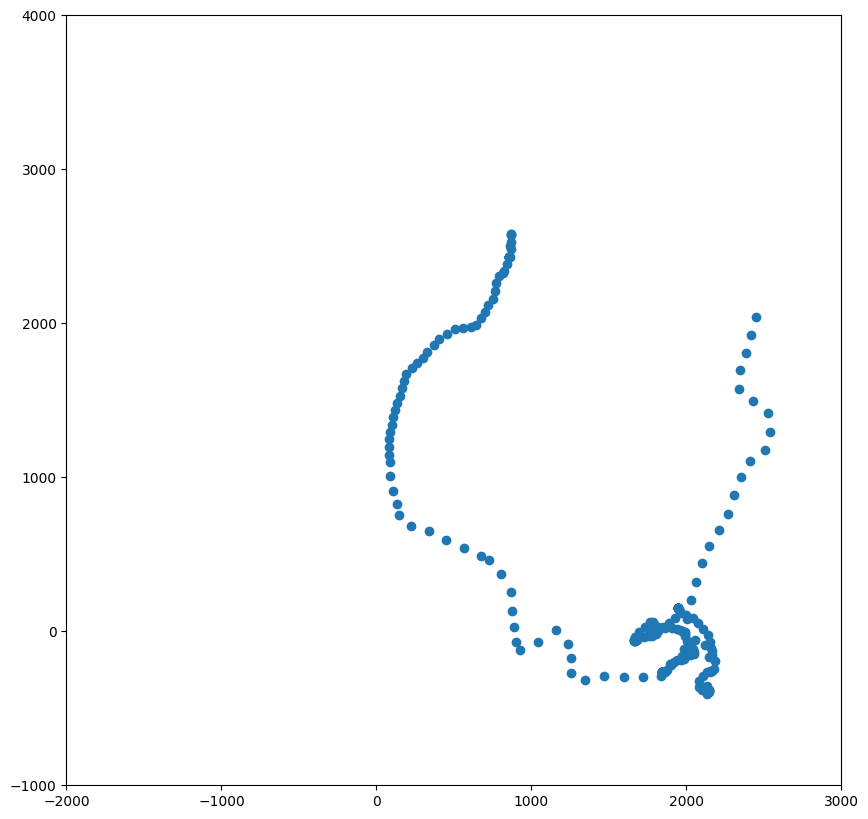

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(graph_data.loc[graph_data['roundNum'] == 11]['player4_x'], graph_data.loc[graph_data['roundNum'] == 11]['player4_y'])
plt.xlim(-2000, 3000)
plt.ylim(-1000, 4000)